In [1]:
import obspy
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from collections import namedtuple
import tqdm
from obspy.geodetics.base import gps2dist_azimuth
from obspy.geodetics import locations2degrees
import seaborn as sns
from obspy.taup import TauPyModel
from obspy.geodetics import degrees2kilometers
model = TauPyModel(model="ak135")
import multiprocessing
from p_tqdm import p_imap
import ipywidgets

In [2]:
test=obspy.read_events("./130_used_events/201308312352A")

In [3]:
test[0].origins[0]

Origin
	 resource_id: ResourceIdentifier(id="smi:local/cmtsolution/201308312352A/origin#cmt")
	        time: UTCDateTime(2013, 8, 31, 23, 52, 8, 890000)
	   longitude: 148.12
	    latitude: 47.86
	       depth: 389290.0
	 origin_type: 'centroid'
	      region: 'NORTHWEST OF KURIL ISLANDS'

In [4]:
test[0].resource_id.id.split("/")[-2]

'201308312352A'

In [5]:
# get all events info
Event=namedtuple("Event",["lon","lat","dep"])

In [6]:
events={}
events_obspy=obspy.read_events("./130_used_events/*")
for each_event in events_obspy:
    event_id=each_event.resource_id.id.split("/")[-2]
    origin=each_event.origins[0]
    events[event_id]=Event(origin.longitude,origin.latitude,origin.depth/1000)

In [7]:
events

{'200708020237A': Event(lon=141.8059, lat=46.8397, dep=3.083),
 '200710061238A': Event(lon=147.4461, lat=18.84, dep=34.1462),
 '200712251404A': Event(lon=142.3646, lat=38.4043, dep=40.6383),
 '200803031349A': Event(lon=121.2212, lat=19.9665, dep=22.5853),
 '200805202042A': Event(lon=108.5373, lat=53.3206, dep=11.4748),
 '200806041703A': Event(lon=139.1478, lat=41.6007, dep=201.7951),
 '200807080742A': Event(lon=128.6363, lat=27.3384, dep=46.5492),
 '200808050949A': Event(lon=105.5676, lat=32.6947, dep=1.4055),
 '200808151025A': Event(lon=124.37, lat=13.07, dep=9.7857),
 '200808160401A': Event(lon=98.3157, lat=52.1615, dep=17.925),
 '200808211224A': Event(lon=97.9967, lat=24.9215, dep=8.516),
 '200808270135A': Event(lon=104.0117, lat=51.7641, dep=19.6052),
 '200808300830A': Event(lon=102.0393, lat=26.1872, dep=15.0497),
 '200809220731A': Event(lon=140.5017, lat=41.4685, dep=145.1055),
 '200810010938A': Event(lon=138.88, lat=30.21, dep=393.77),
 '200810060830A': Event(lon=90.4999, lat=29

In [8]:
# load stations
Station=namedtuple("Station",["lon","lat","elv"])

In [9]:
stations={}
station_array=np.loadtxt("./STATIONS",dtype=np.str)
for row in station_array:
    station_id=(row[0],row[1])
    stations[station_id]=Station(float(row[3]),float(row[2]),float(row[4]))

In [10]:
stations

{('JGPD', '1U'): Station(lon=128.083237, lat=41.994331, elv=2648.0),
 ('MDPD', '1U'): Station(lon=128.198044, lat=41.970928, elv=1799.0),
 ('PDBD', '1U'): Station(lon=128.125595, lat=41.987091, elv=2164.0),
 ('PSRD', '1U'): Station(lon=128.621964, lat=41.938141, elv=1101.0),
 ('SHRD', '1U'): Station(lon=128.791214, lat=41.945759, elv=1041.0),
 ('SMSD', '1U'): Station(lon=128.318344, lat=41.966301, elv=1443.0),
 ('M01', '2F'): Station(lon=120.289238, lat=23.86167, elv=9.8),
 ('M02', '2F'): Station(lon=120.308571, lat=23.857361, elv=10.2),
 ('M03', '2F'): Station(lon=120.325188, lat=23.851271, elv=12.6),
 ('M04', '2F'): Station(lon=120.346558, lat=23.84272, elv=16.3),
 ('M05', '2F'): Station(lon=120.362282, lat=23.8395, elv=18.6),
 ('M06', '2F'): Station(lon=120.382019, lat=23.84329, elv=20.7),
 ('M07', '2F'): Station(lon=120.400917, lat=23.839781, elv=25.2),
 ('M08', '2F'): Station(lon=120.418449, lat=23.84539, elv=29.5),
 ('M09', '2F'): Station(lon=120.440239, lat=23.841471, elv=27.6),

In [11]:
len(stations)*len(events)

261690

## calculate gcarc

In [13]:
Gcarc=namedtuple("Gcarc",["event_id","station_id","gcarc"])
gcarc_result=[]
for each_event_id in tqdm.tqdm_notebook(events,total=len(events)):
    for each_station_id in stations:
        each_event=events[each_event_id]
        each_station=stations[each_station_id]
        distance_degree=locations2degrees(each_event.lat,each_event.lon,each_station.lat,each_station.lon)
        gcarc_result.append(Gcarc(each_event_id,each_station_id,distance_degree))

In [14]:
gcarc_values=[item.gcarc for item in gcarc_result]

Text(0, 0.5, 'frequency')

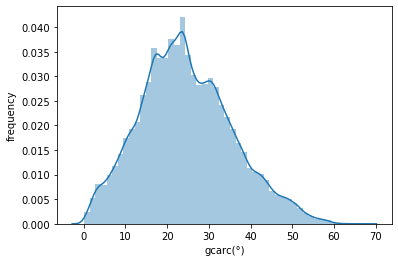

In [15]:
sns.distplot(gcarc_values)
plt.xlabel("gcarc(°)")
plt.ylabel("frequency")

## calculate the travel times

In [16]:
Travel=namedtuple("Travel",["event_id","station_id","time"])

In [61]:
Travel=namedtuple("Travel",["event_id","station_id","time"])
surface_result=[]
for each_event_id in tqdm.tqdm(events,total=len(events)):
    for each_station_id in stations:
        each_event=events[each_event_id]
        each_station=stations[each_station_id]
        distance_degree=locations2degrees(each_event.lat,each_event.lon,each_station.lat,each_station.lon)
        arrivals=model.get_ray_paths(source_depth_in_km=each_event.dep, distance_in_degree=distance_degree, phase_list=["3.0kmps"])
        surface_result.append(Travel(each_event_id,each_station_id,arrivals[0].time))

  0%|          | 0/130 [00:00<?, ?it/s]/Users/ziyixi/anaconda3/envs/seismology/lib/python3.6/site-packages/obspy/taup/tau_branch.py:496: UserWarning: Resizing a TauP array inplace failed due to the existence of other references to the array, creating a new array. See Obspy #2280.
  warnings.warn(msg)
100%|██████████| 130/130 [08:09<00:00,  3.60s/it]


In [62]:
surface_result

[Travel(event_id='200708020237A', station_id=('JGPD', '1U'), time=404.50387417328557),
 Travel(event_id='200708020237A', station_id=('MDPD', '1U'), time=402.24488691102647),
 Travel(event_id='200708020237A', station_id=('PDBD', '1U'), time=403.64259942976156),
 Travel(event_id='200708020237A', station_id=('PSRD', '1U'), time=392.93290847235727),
 Travel(event_id='200708020237A', station_id=('SHRD', '1U'), time=388.8302972628),
 Travel(event_id='200708020237A', station_id=('SMSD', '1U'), time=399.50306859300133),
 Travel(event_id='200708020237A', station_id=('M01', '2F'), time=1064.1501655058914),
 Travel(event_id='200708020237A', station_id=('M02', '2F'), time=1063.9442389166561),
 Travel(event_id='200708020237A', station_id=('M03', '2F'), time=1063.8429116634036),
 Travel(event_id='200708020237A', station_id=('M04', '2F'), time=1063.7356776207566),
 Travel(event_id='200708020237A', station_id=('M05', '2F'), time=1063.5598253292653),
 Travel(event_id='200708020237A', station_id=('M06',

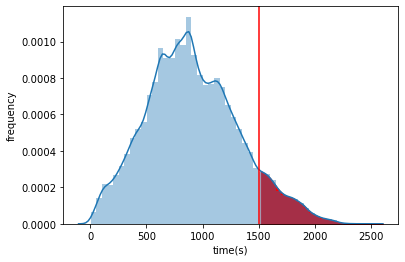

In [69]:
surftime_values=[item.time for item in surface_result]
ax=sns.distplot(surftime_values)
plt.xlabel("time(s)")
plt.ylabel("frequency")
p = plt.axvline(x=1500,color='red')
kde_x, kde_y = ax.lines[0].get_data()
ax.fill_between(kde_x, kde_y, where=(kde_x>1500) , 
                interpolate=True, color='red')

In [70]:
surftime_values=np.array(surftime_values)
len(surftime_values[surftime_values>=1500])/len(surftime_values)

0.0892200695479384

In [64]:
surface_time_less_130km=[]
for item in surface_result:
    event_id=item.event_id
    dep=events[event_id].dep
    if(dep<=130):
        surface_time_less_130km.append(item.time)

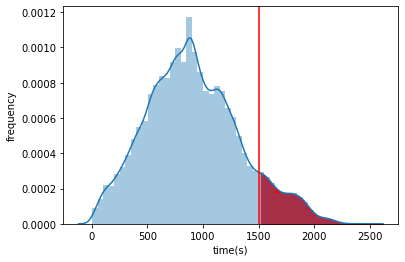

In [66]:
ax=sns.distplot(surface_time_less_130km)
plt.xlabel("time(s)")
plt.ylabel("frequency")
p = plt.axvline(x=1500,color='red')
kde_x, kde_y = ax.lines[0].get_data()
ax.fill_between(kde_x, kde_y, where=(kde_x>1500) , 
                interpolate=True, color='red')

In [67]:
surface_time_less_130km=np.array(surface_time_less_130km)
per=len(surface_time_less_130km[surface_time_less_130km>=1500])/len(surface_time_less_130km)

In [68]:
per

0.09810590138458991

In [19]:
# generate station-event pairs for all 
events_pairs=[]
stations_pairs=[]
for each_event_id in tqdm.tqdm_notebook(events,total=len(events)):
    for each_station_id in stations:
        events_pairs.append(each_event_id)
        stations_pairs.append(each_station_id)

In [20]:
len(events_pairs),len(stations_pairs)

(261690, 261690)

In [21]:
Travel=namedtuple("Travel",["event_id","station_id","time"])
def kernel(ziped_event_station_id):
    each_event_id,each_station_id=ziped_event_station_id
    each_event=events[each_event_id]
    each_station=stations[each_station_id]
    distance_degree=locations2degrees(each_event.lat,each_event.lon,each_station.lat,each_station.lon)
    arrivals=model.get_ray_paths(source_depth_in_km=each_event.dep, distance_in_degree=distance_degree, phase_list=["s","S"])
    return Travel(each_event_id,each_station_id,arrivals[0].time)

In [22]:
with multiprocessing.Pool(processes=12) as pool:
    s_result=list(tqdm.tqdm_notebook(pool.imap(kernel,zip(events_pairs,stations_pairs)),total=len(events_pairs)))

/Users/ziyixi/anaconda3/envs/seismology/lib/python3.6/site-packages/obspy/taup/tau_branch.py:496: UserWarning: Resizing a TauP array inplace failed due to the existence of other references to the array, creating a new array. See Obspy #2280.
  warnings.warn(msg)
/Users/ziyixi/anaconda3/envs/seismology/lib/python3.6/site-packages/obspy/taup/tau_branch.py:496: UserWarning: Resizing a TauP array inplace failed due to the existence of other references to the array, creating a new array. See Obspy #2280.
  warnings.warn(msg)


/Users/ziyixi/anaconda3/envs/seismology/lib/python3.6/site-packages/obspy/taup/tau_branch.py:496: UserWarning: Resizing a TauP array inplace failed due to the existence of other references to the array, creating a new array. See Obspy #2280.
  warnings.warn(msg)
/Users/ziyixi/anaconda3/envs/seismology/lib/python3.6/site-packages/obspy/taup/tau_branch.py:496: UserWarning: Resizing a TauP array inplace failed due to the existence of other references to the array, creating a new array. See Obspy #2280.
  warnings.warn(msg)
/Users/ziyixi/anaconda3/envs/seismology/lib/python3.6/site-packages/obspy/taup/tau_branch.py:496: UserWarning: Resizing a TauP array inplace failed due to the existence of other references to the array, creating a new array. See Obspy #2280.
  warnings.warn(msg)
/Users/ziyixi/anaconda3/envs/seismology/lib/python3.6/site-packages/obspy/taup/tau_branch.py:496: UserWarning: Resizing a TauP array inplace failed due to the existence of other references to the array, creating

In [23]:
s_result

[Travel(event_id='200708020237A', station_id=('JGPD', '1U'), time=279.63174531885659),
 Travel(event_id='200708020237A', station_id=('MDPD', '1U'), time=278.13757410908693),
 Travel(event_id='200708020237A', station_id=('PDBD', '1U'), time=279.06208463285577),
 Travel(event_id='200708020237A', station_id=('PSRD', '1U'), time=271.97699859145104),
 Travel(event_id='200708020237A', station_id=('SHRD', '1U'), time=269.26216205387163),
 Travel(event_id='200708020237A', station_id=('SMSD', '1U'), time=276.32381593077957),
 Travel(event_id='200708020237A', station_id=('M01', '2F'), time=648.08282161983368),
 Travel(event_id='200708020237A', station_id=('M02', '2F'), time=647.99540138663565),
 Travel(event_id='200708020237A', station_id=('M03', '2F'), time=647.95238550131887),
 Travel(event_id='200708020237A', station_id=('M04', '2F'), time=647.9068618225532),
 Travel(event_id='200708020237A', station_id=('M05', '2F'), time=647.83220740392346),
 Travel(event_id='200708020237A', station_id=('M0

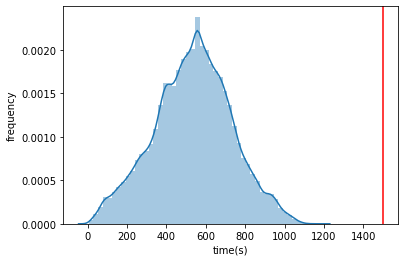

In [24]:
s_time=[item.time for item in s_result]
ax=sns.distplot(s_time)
plt.xlabel("time(s)")
plt.ylabel("frequency")
p = plt.axvline(x=1500,color='red')
kde_x, kde_y = ax.lines[0].get_data()
ax.fill_between(kde_x, kde_y, where=(kde_x>1500) , 
                interpolate=True, color='red')

In [25]:
locations2degrees(33.8399,136.5974,34.8635,135.5706)

1.3290320197211674